In [30]:
import fourier
import data_from_input
from source import source

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode, odeint
from scipy import constants as const
from numpy.fft import fft, rfft, irfft
from scipy.interpolate import griddata
from scipy import ndimage

from math import floor
import warnings
import struct #для распаковки .bin
import subprocess #для создания списка файлов

In [2]:
# Set the font family and size to use for Matplotlib figures.
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

## Обобщение на случай падающего сигнала с огибающей в форме гаусса. 

Линейная поляризация

\begin{equation}
e^{\left( -\left(\frac{x_s - t}{\tau} \right)^2\right)} \sin{(x_s - t)}= \frac{s}{2}  \frac{\beta_y}{1 - \beta_x} x_s,\quad s = n_0/a \quad \quad (1)
\end{equation}


\begin{equation}
\beta_x^2 + \beta_y^2 = 1 \quad (2)
\end{equation}

$(1)^2$ с учётом $(2)$:
\begin{equation}
e^{\left( -2\left(\frac{x_s - t}{\tau} \right)^2\right)}  \left(\sin{(x_s - t)}\right)^2= \left(\frac{s}{2}\right)^2  \frac{1-\beta_x^2}{(1 - \beta_x)^2} x_s^2
\end{equation}


\begin{equation}
\frac{dx_s}{dt} =\frac{e^{\left( -2\left(\frac{x_s - t}{\tau} \right)^2\right)}\left(\sin{(x_s - t)}\right)^2 - (sx_s/2)^2}{e^{\left( -2\left(\frac{x_s - t}{\tau} \right)^2\right)}\left(\sin{(x_s - t)}\right)^2 + (sx_s/2)^2}
\end{equation}

Циркулярная поляризация

\begin{equation}
e^{\left( -\left(\frac{x_s - t}{\tau} \right)^2\right)} \sin{(x_s - t)}= \frac{s}{2}  \frac{\beta_y}{1 - \beta_x} x_s,\quad s = n_0/a \quad \quad (1)
\end{equation}
\begin{equation}
e^{\left( -\left(\frac{x_s - t}{\tau} \right)^2\right)} \cos{(x_s - t)} = \frac{s}{2}  \frac{\beta_z}{1 - \beta_x} x_s \quad \quad (2)
\end{equation}


\begin{equation}
\beta_x^2 + \beta_y^2+ \beta_z^2 = 1 \quad (3)
\end{equation}

$(1)^2 + (2)^2$ с учётом $(3)$:
\begin{equation}
e^{\left( -2\left(\frac{x_s - t}{\tau} \right)^2\right)}= \left(\frac{s}{2}\right)^2  \frac{1-\beta_x^2}{(1 - \beta_x)^2} x_s^2
\end{equation}


\begin{equation}
\frac{dx_s}{dt} =\frac{e^{\left( -2\left(\frac{x_s - t}{\tau} \right)^2\right)} - (sx_s/2)^2}{e^{\left( -2\left(\frac{x_s - t}{\tau} \right)^2\right)} + (sx_s/2)^2}
\end{equation}

In [3]:
def rhs_circ(t,x):
    if t-shift-x<0:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau)**2) - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau)**2) + (s/2*x)**2))
    else:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau1)**2) - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau1)**2) + (s/2*x)**2))
    return dxdt

def rhs_lin(t,x):
    if t-shift-x<0:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau)**2)*(np.sin(t-shift-x))**2 - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau)**2)*(np.sin(t-shift-x))**2 + (s/2*x)**2))
    else:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau1)**2)*(np.sin(t-shift-x))**2 - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau1)**2)*(np.sin(t-shift-x))**2 + (s/2*x)**2))
    return dxdt

def incidence(tt):
    if tt-shift<0:
        dxdt = np.exp((-1)*((tt-shift)/tau)**2)
    else:
        dxdt = np.exp((-1)*((tt-shift)/tau1)**2)
    return dxdt

In [4]:
# для пересчёта в размерные единицы
Omega = 2.35456e+15
LightVelocity = 2.99792e+10

In [5]:
a = 40.0
n_0 = 4.0
s = n_0/a

tau = 10e-15*Omega/np.sqrt(2*np.log(2)) # ширина для переднего фронта
tau1 = 10e-15*Omega/np.sqrt(2*np.log(2)) # ширина для заднего фронта
shift = 3.6*tau # задержка падающего импульса
T = 10*tau1 # полное время расчета
dt = 0.002 # шаг по времени

#-- расчёт с поиском подходящего шага --#
#-- критерий отбора- глубина отжатия больше 20 нм --#

while True:
    r = ode(rhs_lin).set_integrator('lsoda', rtol = 1.0e-10)
    r.set_initial_value(0, 0)
    x = [0]
    t = [0]
    while r.successful() and r.t < T:
        r.integrate(r.t+dt)
        x.append(r.y[0])
        t.append(r.t)
    if np.max(x)*LightVelocity/Omega*1.e+4 >= 0.02:
        break
    else:
        dt += 0.0001
print(dt)

KeyboardInterrupt: 

In [9]:
x = np.array(x)
t = np.array(t)
dxdt = np.array([rhs_lin(i,j) for i,j in zip(t,x)])

mask = np.where(x<0)
x[mask] = 1.e-4
dxdt[mask] = -1.e-4

#-- находим отраженное поле --#
beta_z = np.zeros(len(t)-1)
for i in range(1, len(t)-1):
    if t[i]-shift-x[i]<0:
        beta_z[i] = np.exp(-((t[i]-x[i]-shift)/tau) **2) * np.sin(t[i]-x[i]) *2/s/x[i]*(1-dxdt[i])
    else:
        beta_z[i] = np.exp(-((t[i]-x[i]-shift)/tau1)**2) * np.sin(t[i]-x[i]) *2/s/x[i]*(1-dxdt[i])
az_r = n_0/2*beta_z/(1+dxdt[1:])*x[1:]
az_r = griddata((t[1:] + x[1:]), az_r, t[1:], method = "cubic")

az_i = np.array([a*incidence(n)*np.sin(n)  for n in t]) # падающее поле

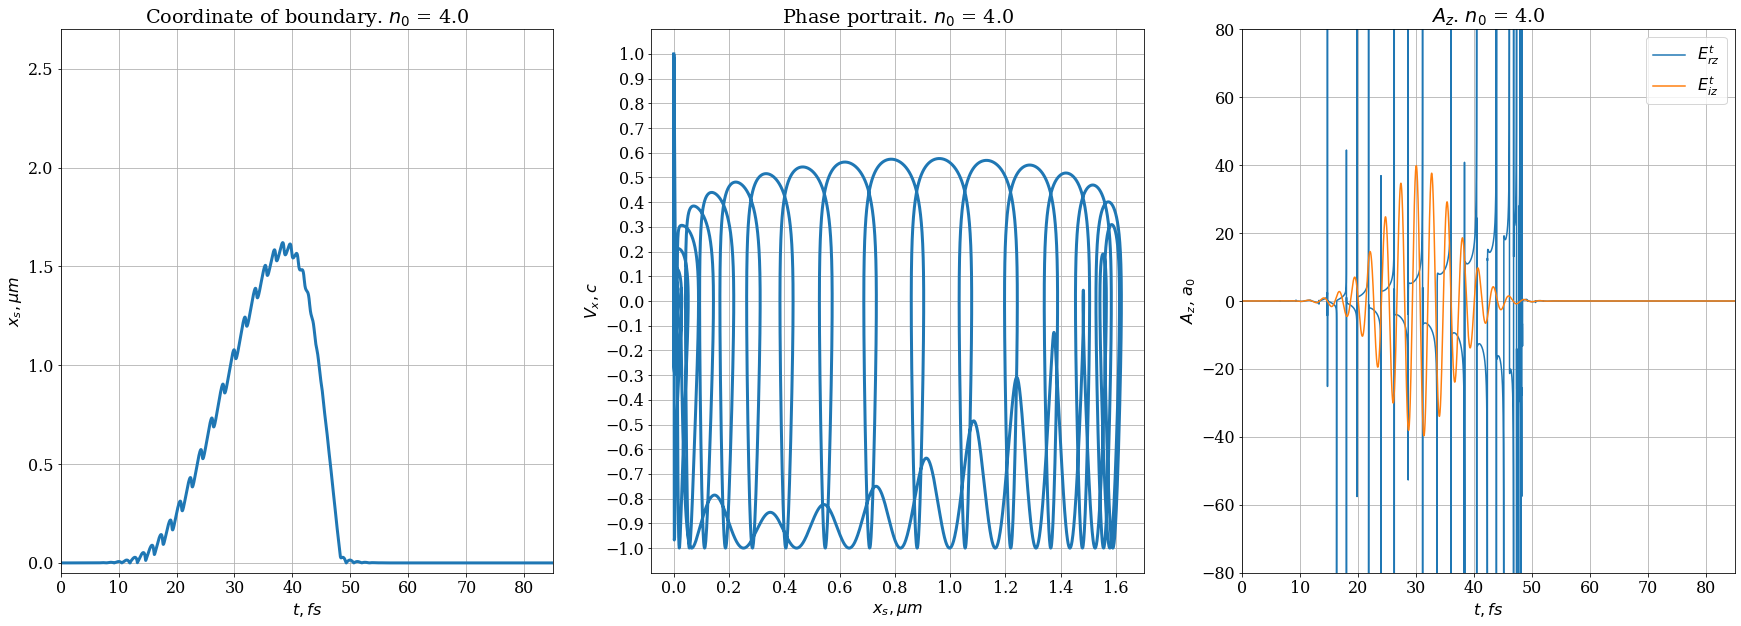

In [10]:
max_t = T/Omega*1.e+15
max_x = 2.7

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30,10))
#plt.figure(figsize = (5,5))
ax1.plot(t[:]/Omega*1.e+15, x[:]*LightVelocity/Omega*1.e+4, linewidth = 3.0)
ax1.set_xlabel(r"$t, fs$")
ax1.set_ylabel(r"$x_s, \mu m$")
ax1.set_title("Coordinate of boundary." + r" $n_0$ = {}".format(n_0))
ax1.grid()
ax1.axis([0, max_t, -0.05, max_x])
#plt.show()

#plt.figure(figsize = (5,5))
ax2.plot(x[:]*LightVelocity/Omega*1.e+4, dxdt[:], linewidth = 3.0)
ax2.set_xlabel(r"$x_s, \mu m$")
ax2.set_ylabel(r"$V_x, c$")
ax2.set_yticks(np.arange(-1.0,1.1,0.1))
ax2.set_title("Phase portrait." + r" $n_0$ = {}".format(n_0))
ax2.grid()
#plt.show()

#plt.figure(figsize = (5,5))
ax3.plot((t[1:])/Omega*1.e+15, az_r[:], label = r'$E^t_{rz}$', linewidth = 1.5)
ax3.plot(t[:]/Omega*1.e+15, az_i, label = r'$E^t_{iz}$', linewidth = 1.5)
ax3.set_title("$A_z$." + r" $n_0$ = {}".format(n_0))
ax3.set_xlabel(r"$t, fs$")
ax3.set_ylabel(r"$A_z$, $a_0$")
ax3.axis([0, max_t, -2*a, +2*a])
ax3.legend()
ax3.grid()
#plt.show()

In [70]:
name = r"./data/source/l_long_70.0_2021-06-28_10-40-04"
name = r"./data/source/l_long_30.0_2021-07-05_10-17-17"
#name = r"/home/nikita/Documents/science/disk_backup/1D/linear_smalltail/l_long_30.0_2021-07-05_10-17-17"
n_0 = 30.0

l = subprocess.check_output(['ls',], cwd = name+ r'/BasicOutput/data/by2dxy')
files = l.split()
files = [i.decode('ascii') for i in files]
#print(files)

In [71]:
def reparse1(files, name, field, norm):
    bz = []
    for file in files:
        with open(name +r"/BasicOutput/data/" + field + "/" + file, mode = "rb") as f:
            line_of_data = np.frombuffer(f.read(), dtype = np.float32)
            #by_field_2_i = np.reshape(line_of_data, shape_2dfield)/RelativisticField
            bz.append(line_of_data/norm)
    return bz

In [72]:
Omega = 2.35456e+15
LightVelocity = 2.99792e+10
a = 27.8508

RelativisticField = 1.33872e+08
FocalSpotWidthFWHM = 5e-4
LightVelocity = 2.99792e+10

ElectronsPerCell = 6.53235e+15/5

In [41]:
delta_t, delta_x, a_rel, n, focal_spot_fwhm = data_from_input.parameters_from_input(name)

In [42]:
bz, x_array = data_from_input.reparse(name, "bz2dxy",a_rel, delta_x)
by = np.array(reparse1(files, name, "by2dxy",a_rel))
ey = np.array(reparse1(files, name, "ey2dxy",a_rel))
ez = np.array(reparse1(files, name, "ez2dxy",a_rel))

n_e = data_from_input.reparse(name, "electron2dxy", n, 0)

In [43]:
by_r = (ez+by)/2
by_i = (-ez+by)/2

bz_r = (-ey+bz)/2
bz_i = (ey+bz)/2

In [44]:
mask_2d = np.where((np.sqrt(bz_r**2 + by_r**2) > 5e-3), 1, 0)
mask_ne = np.where(n_e > 9e-1, 0.99, 0.01)

In [45]:
range1 = (3, 10)

In [46]:
del ez, ey, by, bz

In [47]:
bz_i.shape

(2142, 10000)

In [48]:
filtered_bz_r1 = source(bz_i, bz_r, range1)
#filtered_by_r1 = source(by_i, by_r, range1)
t = np.linspace(0,200, filtered_bz_r1.shape[0])

In [49]:
forier_bz_i, forier_bz_r, max_forier_basez, omegaz, flambdaz, lforier_bz_i, lforier_bz_r = fourier.fourier_of_field(bz_i[100,:], bz_r[2000,:], 0.8, True)
spec_filtered = fourier.spec_filter(lforier_bz_r, flambdaz, range1, "tophat")

In [50]:
def filter_gauss(w, shift, sigma):
    return np.exp(-((w-shift)/sigma)**2/2)

In [51]:
field_r = (bz_r)[:,6500]
filter_range = range1

rfft_i = abs(np.fft.rfft(bz_i, axis = 0))
argmax = np.unravel_index(np.argmax(rfft_i, axis = None), rfft_i.shape)[0]

k_x = np.arange(1,np.shape(rfft_i)[0])/argmax
lambda_i = 0.8/k_x
filter_range_i = (np.where(lambda_i>filter_range[1])[0][-1], np.where(lambda_i>filter_range[0])[0][-1])

filtered_fft_r = np.zeros(np.shape(abs(np.fft.rfft((field_r)))), dtype = "complex")
#filtered_fft_r[filter_range_i[0]:filter_range_i[1]] = (np.fft.rfft(field_r, axis = 0))[filter_range_i[0]:filter_range_i[1]]
filter_shape = filter_gauss(np.arange(len(filtered_fft_r)), sum(filter_range_i)/2, (filter_range_i[1] - filter_range_i[0])/2)
filter_shape[filter_range_i[0]:int(sum(filter_range_i)/2)] = abs(np.ones(len(field_r)))[filter_range_i[0]:int(sum(filter_range_i)/2)]
filter_shape[0:filter_range_i[0]] = 0
filtered_fft_r = np.fft.rfft(field_r, axis = 0)*filter_shape
filtered_r = np.fft.irfft(filtered_fft_r)
t1 = np.linspace(0,200, filtered_r.shape[0])

In [52]:
filter_range_i

(4, 18)

(-0.1, 6.0, 0.0, 1.1)

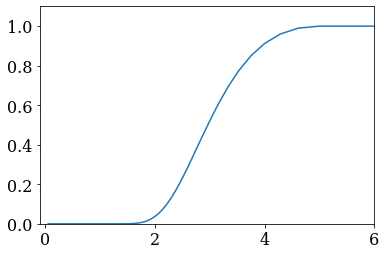

In [53]:
plt.plot(lambda_i ,filter_shape[:-1])
plt.axis([-0.1,6,0,1.1])

In [54]:
def rhs_circ(t,x):
    if t-shift-x<0:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau)**2) - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau)**2) + (s/2*x)**2))
    else:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau1)**2) - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau1)**2) + (s/2*x)**2))
    return dxdt

def rhs_lin(t,x):
    if t-shift-x<0:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau)**2)*(np.sin(t-x+1e-3))**2 - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau)**2)*(np.sin(t-x+1e-3))**2 + (s/2*x)**2))
    else:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau1)**2)*(np.sin(t-x+1e-3))**2 - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau1)**2)*(np.sin(t-x+1e-3))**2 + (s/2*x)**2))
    return dxdt

def incidence(tt):
    if tt-shift<0:
        dxdt = np.exp((-1)*((tt-shift)/tau)**2)
    else:
        dxdt = np.exp((-1)*((tt-shift)/tau1)**2)
    return dxdt

In [55]:
a = 27.85
n_0 = 30.0
s = n_0/a

tau = 10e-15*Omega/np.sqrt(2*np.log(2)) # ширина для переднего фронта
tau1 = 10e-15*Omega/np.sqrt(2*np.log(2)) # ширина для заднего фронта
shift = 1.5*tau # задержка падающего импульса
T = 10*tau1 # полное время расчета
dt = 0.001 # шаг по времени

#-- расчёт с поиском подходящего шага --#
#-- критерий отбора- глубина отжатия больше 20 нм --#

while True:
    r = ode(rhs_lin).set_integrator('lsoda', rtol = 1.0e-10)
    r.set_initial_value(0, 0)
    x = [0]
    t = [0]
    while r.successful() and r.t < T:
        r.integrate(r.t+dt)
        x.append(r.y[0])
        t.append(r.t)
    if np.max(x)*LightVelocity/Omega*1.e+4 >= 0.02:
        break
    else:
        dt += 0.00005
print(dt)

0.001


In [56]:
x = np.array(x)
t = np.array(t)
dxdt = np.array([rhs_lin(i,j) for i,j in zip(t,x)])

mask = np.where(x<0)
x[mask] = 1.e-4
dxdt[mask] = -1.e-4

#-- находим отраженное поле --#
beta_z = np.zeros(len(t)-1)
for i in range(1, len(t)-1):
    if t[i]-shift-x[i]<0:
        beta_z[i] = np.exp(-((t[i]-x[i]-shift)/tau) **2) * np.sin(t[i]-x[i]) *2/s/x[i]*(1-dxdt[i])
    else:
        beta_z[i] = np.exp(-((t[i]-x[i]-shift)/tau1)**2) * np.sin(t[i]-x[i]) *2/s/x[i]*(1-dxdt[i])
az_r = n_0/2*beta_z/(1+dxdt[1:])*x[1:]
az_r = griddata((t[1:] + x[1:]), az_r, t[1:], method = "cubic")

az_i = np.array([a*incidence(n)*np.sin(n)  for n in t]) # падающее поле

In [57]:
filtered_bz_r1.shape

(2142, 10000)

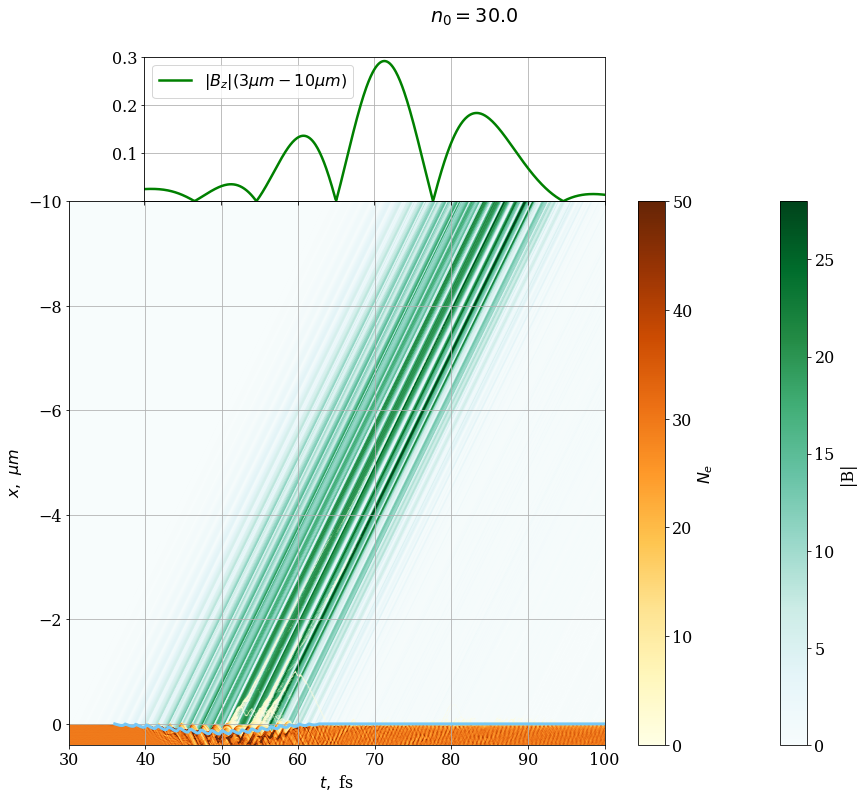

In [67]:
fig = plt.figure(figsize = (15,10))


fig.suptitle("$n_0 = {}$".format(n_0), y = 1.15)
ax1 = plt.axes()  # standard axes

imag3 = ax1.imshow(n_e.T, vmax = 50, vmin = 0, cmap = "YlOrBr", extent = (0, 200, 10, -30), aspect =  "auto")

#imag1 = ax1.imshow((np.sqrt((filtered_by_r1)**2 + (filtered_bz_r1)**2)).T, vmax = 6, vmin = 0, cmap = "BuGn", extent = (0, 400, 30, -30), aspect = "auto")
#imag1 = ax1.imshow((np.sqrt((bz_r)**2)).T, vmax = 30, vmin = 0, cmap = "BuGn", extent = (0, 200, 10, -30), aspect = "auto")
#imag1 = ax1.imshow(abs(filtered_bz_r1.T), vmax = 0.3, vmin = 0, cmap = "BuGn", extent = (0, 200, 10, -30), aspect = "auto")
imag1 = ax1.imshow(abs(bz_r.T), vmax = 28, vmin = 0, cmap = "BuGn", extent = (0, 200, 10, -30), aspect = "auto")
cbar1 = fig.colorbar(imag1)
cbar2 = fig.colorbar(imag3)
cbar1.set_label("|B|")
cbar2.set_label(r'$N_e$')
imag2 = ax1.imshow(n_e.T, alpha = mask_ne.T, vmax = 50, vmin = 0, cmap = "YlOrBr", extent = (0, 200, 10, -30), aspect =  "auto")

plt.plot(t[:]/Omega*1.e+15 + 36.0, x[:]*LightVelocity/Omega*1.e+4, linewidth = 3.0, c = "#76C8F7")

ax1.axis([30, 100, 0.4, -10])

plt.xlabel("$t,$ fs")
plt.ylabel("$x,$ $\mu m$")
ax1.grid()

yticks = np.arange(0,2.6*10,0.1*10)/10
str_yticks = [str(i) for i in yticks]

ax2 = plt.axes([0.195, 0.88, 0.426, 0.2])
#ax2.plot(t, ((np.sqrt((filtered_by_r1)**2 + (filtered_bz_r1)**2)))[:,2666], linewidth = 2.5, c = "g", label = "|B|")
#ax2.plot(t, ((np.sqrt((filtered_bz_r1)**2)))[:,3866], linewidth = 2.5, c = "g", label = r'$|B|({}\mu m-{}\mu m)$'.format(range1[0], range1[1]))
ax2.plot(t1, np.abs(filtered_bz_r1[:,6550]), linewidth = 2.5, c = "g", label = r'$|B_z|({}\mu m-{}\mu m)$'.format(range1[0], range1[1]))
#ax2.plot(t, abs((bz_r)[:,3946]), linewidth = 1.5, label = "|B$_z$|")
#ax2.plot(t, abs(filtered_bz_r1[:,2666]), linewidth = 1.5, label = "|B$_z$|")
#ax2.plot(t, abs((filtered_bz_r1)[:,3866]), linewidth = 1.5, label = "|B$_z$|")
ax2.set_xticks(np.arange(0,200,10))
ax2.set_yticks(yticks)
ax2.axis([40, 100,0.0,0.3])
ax2.set_xticklabels([])
ax2.set_yticklabels(["",] + str_yticks[1:])
ax2.legend(loc = "best")
ax2.grid()



In [3]:
name = r"./data/source/l_steep_70.0_2021-06-28_10-40-06"
name = r"./data/source//l_long_70.0_2021-07-05_10-17-19"
#name = r"/home/nikita/Documents/science/disk_backup/1D/linear_smalltail/l_long_70.0_2021-07-05_10-17-19"
n_0 = 70.0

l = subprocess.check_output(['ls',], cwd = name+ r'/BasicOutput/data/by2dxy')
files = l.split()
files = [i.decode('ascii') for i in files]
#print(files)

def reparse1(files, name, field, norm):
    bz = []
    for file in files:
        with open(name +r"/BasicOutput/data/" + field + "/" + file, mode = "rb") as f:
            line_of_data = np.frombuffer(f.read(), dtype = np.float32)
            #by_field_2_i = np.reshape(line_of_data, shape_2dfield)/RelativisticField
            bz.append(line_of_data/norm)
    return bz

Omega = 2.35456e+15
LightVelocity = 2.99792e+10
a = 27.8508

RelativisticField = 1.33872e+08
FocalSpotWidthFWHM = 5e-4
LightVelocity = 2.99792e+10

ElectronsPerCell = 6.53235e+15/5

delta_t, delta_x, a_rel, n, focal_spot_fwhm = data_from_input.parameters_from_input(name)

bz, x_array = data_from_input.reparse(name, "bz2dxy",a_rel, delta_x)
by = np.array(reparse1(files, name, "by2dxy",a_rel))
ey = np.array(reparse1(files, name, "ey2dxy",a_rel))
ez = np.array(reparse1(files, name, "ez2dxy",a_rel))

n_e = data_from_input.reparse(name, "electron2dxy", n, 0)

by_r = (ez+by)/2
by_i = (-ez+by)/2

bz_r = (-ey+bz)/2
bz_i = (ey+bz)/2

mask_2d = np.where((np.sqrt(bz_r**2 + by_r**2) > 5e-3), 1, 0)
mask_ne = np.where(n_e > 9e-1, 0.99, 0.01)

In [14]:
range1 = (3, 10)
filtered_bz_r1 = source(bz_i, bz_r, range1)
#filtered_by_r1 = source(by_i, by_r, range1)
t = np.linspace(0,200, filtered_bz_r1.shape[0])

forier_bz_i, forier_bz_r, max_forier_basez, omegaz, flambdaz, lforier_bz_i, lforier_bz_r = fourier.fourier_of_field(bz_i[100,:], bz_r[300,:], 0.8, True)
spec_filtered = fourier.spec_filter(lforier_bz_r, flambdaz, range1, "tophat")

In [16]:
def filter_gauss(w, shift, sigma):
    return np.exp(-((w-shift)/sigma)**2/2)

field_r = (bz_r)[:,6500]
filter_range = range1

rfft_i = abs(np.fft.rfft(bz_i, axis = 0))
argmax = np.unravel_index(np.argmax(rfft_i, axis = None), rfft_i.shape)[0]

k_x = np.arange(1,np.shape(rfft_i)[0])/argmax
lambda_i = 0.8/k_x
filter_range_i = (np.where(lambda_i>filter_range[1])[0][-1], np.where(lambda_i>filter_range[0])[0][-1])

filtered_fft_r = np.zeros(np.shape(abs(np.fft.rfft((field_r)))), dtype = "complex")
#filtered_fft_r[filter_range_i[0]:filter_range_i[1]] = (np.fft.rfft(field_r, axis = 0))[filter_range_i[0]:filter_range_i[1]]

filter_shape = filter_gauss(np.arange(len(filtered_fft_r)), sum(filter_range_i)/2, (filter_range_i[1] - filter_range_i[0])/1)
filter_shape[filter_range_i[0]:int(sum(filter_range_i)/2)] = abs(np.ones(len(field_r)))[filter_range_i[0]:int(sum(filter_range_i)/2)]
filter_shape[0:filter_range_i[0]] = 0
filtered_fft_r = np.fft.rfft(field_r, axis = 0)*filter_shape
filtered_r = np.fft.irfft(filtered_fft_r, axis = 0)
t1 = np.linspace(0,200, filtered_r.shape[0])

(-0.1, 16.0, 0.0, 1.1)

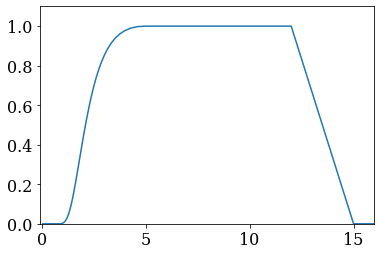

In [17]:
plt.plot(lambda_i ,filter_shape[:-1])
plt.axis([-0.1,16,0,1.1])

In [18]:
def rhs_circ(t,x):
    if t-shift-x<0:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau)**2) - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau)**2) + (s/2*x)**2))
    else:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau1)**2) - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau1)**2) + (s/2*x)**2))
    return dxdt

def rhs_lin(t,x):
    if t-shift-x<0:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau)**2)*(np.sin(t-x+1e-4))**2 - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau)**2)*(np.sin(t-x+1e-4))**2 + (s/2*x)**2))
    else:
        dxdt = ((np.exp((-2)*((t-shift-x)/tau1)**2)*(np.sin(t-x+1e-4))**2 - (s/2*x)**2)/
                (np.exp((-2)*((t-shift-x)/tau1)**2)*(np.sin(t-x+1e-4))**2 + (s/2*x)**2))
    return dxdt

def incidence(tt):
    if tt-shift<0:
        dxdt = np.exp((-1)*((tt-shift)/tau)**2)
    else:
        dxdt = np.exp((-1)*((tt-shift)/tau1)**2)
    return dxdt

In [19]:
a = 27.85
n_0 = 70.0
s = n_0/a

tau = 10e-15*Omega/np.sqrt(2*np.log(2)) # ширина для переднего фронта
tau1 = 10e-15*Omega/np.sqrt(2*np.log(2)) # ширина для заднего фронта
shift = 1.4*tau # задержка падающего импульса
T = 10*tau1 # полное время расчета
dt = 0.002 # шаг по времени

#-- расчёт с поиском подходящего шага --#
#-- критерий отбора- глубина отжатия больше 20 нм --#

while True:
    r = ode(rhs_lin).set_integrator('lsoda', rtol = 1.0e-10)
    r.set_initial_value(0, 0)
    x = [0]
    t = [0]
    while r.successful() and r.t < T:
        r.integrate(r.t+dt)
        x.append(r.y[0])
        t.append(r.t)
    if np.max(x)*LightVelocity/Omega*1.e+4 >= 0.02:
        break
    else:
        dt += 0.0001
print(dt)

0.0033999999999999976


In [20]:
x = np.array(x)
t = np.array(t)
dxdt = np.array([rhs_lin(i,j) for i,j in zip(t,x)])

mask = np.where(x<0)
x[mask] = 1.e-4
dxdt[mask] = -1.e-4

#-- находим отраженное поле --#
beta_z = np.zeros(len(t)-1)
for i in range(1, len(t)-1):
    if t[i]-shift-x[i]<0:
        beta_z[i] = np.exp(-((t[i]-x[i]-shift)/tau) **2) * np.sin(t[i]-x[i]) *2/s/x[i]*(1-dxdt[i])
    else:
        beta_z[i] = np.exp(-((t[i]-x[i]-shift)/tau1)**2) * np.sin(t[i]-x[i]) *2/s/x[i]*(1-dxdt[i])
az_r = n_0/2*beta_z/(1+dxdt[1:])*x[1:]
az_r = griddata((t[1:] + x[1:]), az_r, t[1:], method = "cubic")

az_i = np.array([a*incidence(n)*np.sin(n)  for n in t]) # падающее поле

In [21]:
bz_r.shape

(2142, 10000)

In [5]:
fft_r = np.fft.fftshift(np.fft.fft2(bz_r))
fft_i = np.fft.fftshift(np.fft.fft2(bz_i))

In [9]:
freq_x = (np.arange(fft_i.shape[1]) - fft_i.shape[1]/2) / (np.unravel_index(np.argmax(abs(fft_i)), fft_i.shape)[1]-fft_i.shape[1]/2)
freq_y = (np.arange(fft_i.shape[0]) - fft_i.shape[0]/2) / (np.unravel_index(np.argmax(abs(fft_i)), fft_i.shape)[0]-fft_i.shape[0]/2)

In [10]:
w_x, w_y = np.meshgrid(freq_x, freq_y)

In [39]:
uniform_filter = ndimage.fourier_gaussian(np.fft.fft2(bz_r), sigma= 0.2)

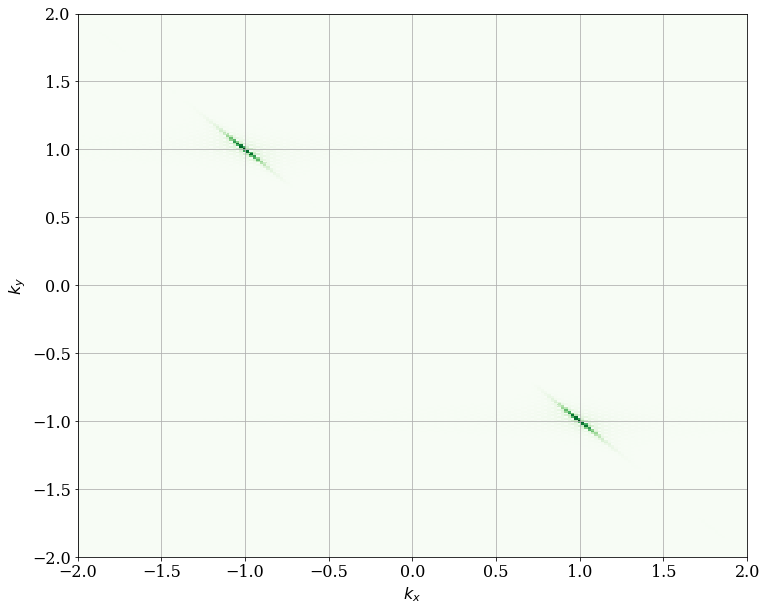

In [40]:
fig = plt.figure(figsize=(12,10))
img1 = plt.pcolormesh((freq_x), (freq_y), abs(np.fft.fftshift(uniform_filter)), cmap='Greens', shading='auto')
#plt.colorbar(img1, ax = ax1)
plt.xlabel(r"$k_x$")
plt.ylabel(r"$k_y$")
plt.axis([-2,2,-2,2])
plt.grid()

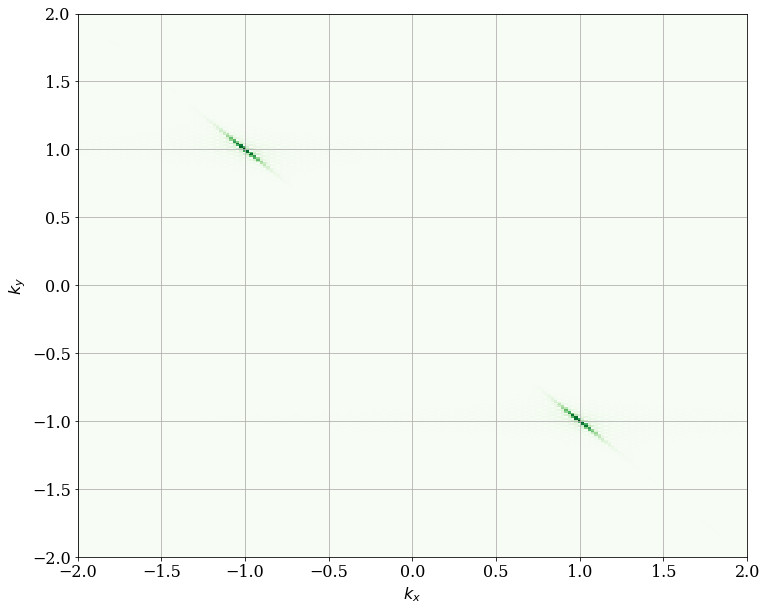

In [36]:
fig = plt.figure(figsize=(12,10))
img1 = plt.pcolormesh((freq_x), (freq_y), abs(fft_r), cmap='Greens', shading='auto')
#plt.colorbar(img1, ax = ax1)
plt.xlabel(r"$k_x$")
plt.ylabel(r"$k_y$")
plt.axis([-2,2,-2,2])
plt.grid()

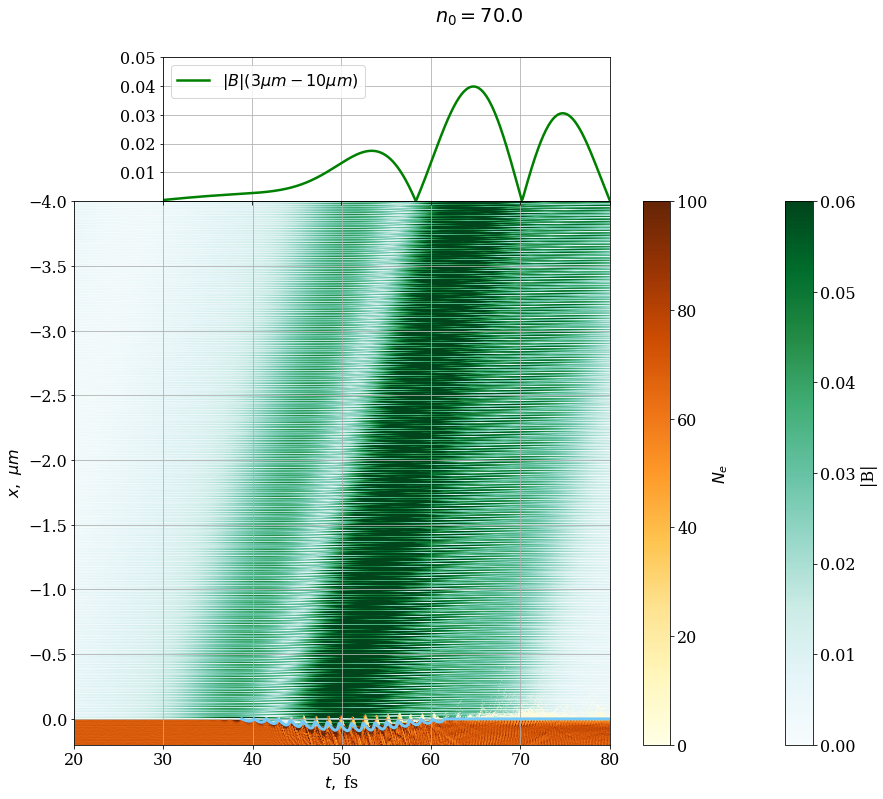

In [22]:
fig = plt.figure(figsize = (15,10))


fig.suptitle("$n_0 = {}$".format(n_0), y = 1.15)
ax1 = plt.axes()  # standard axes

imag3 = ax1.imshow(n_e.T, vmax = 100, vmin = 0, cmap = "YlOrBr", extent = (0, 200, 10, -30), aspect =  "auto")

imag1 = ax1.imshow(abs(filtered_bz_r1).T, vmax = 0.06, vmin = 0, cmap = "BuGn", extent = (0, 200, 10, -30), aspect = "auto")
#imag1 = ax1.imshow((np.sqrt((filtered_bz_r1)**2)).T, vmax = 1, vmin = 0, cmap = "BuGn", extent = (0, 400, 30, -30), aspect = "auto")
cbar1 = fig.colorbar(imag1)
cbar2 = fig.colorbar(imag3)
cbar1.set_label("|B|")
cbar2.set_label(r'$N_e$')
imag2 = ax1.imshow(n_e.T, alpha = mask_ne.T, vmax = 100, vmin = 0, cmap = "YlOrBr", extent = (0, 200, 10, -30), aspect =  "auto")

#ax1.set_xticks(np.arange(0,50,5))

plt.plot(t[:]/Omega*1.e+15 + 38.8, x[:]*LightVelocity/Omega*1.e+4, linewidth = 3.0, c = "#76C8F7")

ax1.axis([20, 80, 0.2, -4])
plt.xlabel("$t,$ fs")
plt.ylabel("$x,$ $\mu m$")
ax1.grid()

#-----------------2-----------------------#
yticks = np.arange(0,1.0*10,0.01*100)/100
str_yticks = [str(i) for i in yticks]

ax2 = plt.axes([0.207, 0.88, 0.414, 0.2])
#ax2.plot(t, ((np.sqrt((filtered_bz_r1)**2)))[:,3466], linewidth = 2.5, c = "g", label = "|B|")

ax2.plot(t1+3, abs(filtered_bz_r1[:,6500]), linewidth = 2.5, c = "g", label = r'$|B|({}\mu m-{}\mu m)$'.format(range1[0], range1[1]))

#ax2.plot(t, abs(filtered_bz_r1[:,2666]), linewidth = 1.5, label = "|B$_z$|")
#ax2.plot(t, abs((filtered_bz_r1)[:,2666]), linewidth = 1.5, label = "|B$_z$|")
ax2.set_xticks(np.arange(0,200,10))
ax2.set_yticks(yticks)
ax2.axis([30, 80,0.0,0.05])
ax2.set_xticklabels([])
ax2.set_yticklabels(["",] + str_yticks[1:])
ax2.legend()
ax2.grid()